In [84]:
import os
from typing import List, TypedDict

from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph, START
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display

In [85]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [86]:
file_configs = [
    {
        "path": "company_profile.txt",
        "title": "Company Profile",
        "description": "A brief overview of the company's history, mission, and values."
    },
    {
        "path": "product_profile.txt",
        "title": "Product Profile",
        "description": "Detailed descriptions of the products offered by the company."
    },
    {
        "path": "complaint_handling.txt",
        "title": "Complaint Handling",
        "description": "Procedures and policies for managing customer complaints effectively."
    }
]

In [87]:
documents: List[Document] = []

In [88]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", " ", ""],
    length_function=len
)

In [89]:
for config in file_configs:
    with open(config["path"], "r", encoding="utf-8") as f:
        content = f.read()
        chunks = text_splitter.split_text(content)
    
        # buat Document object dari setiap chunk
        for i, chunk in enumerate(chunks):
            doc = Document(
                page_content=chunk,
                metadata={
                    "source": config["path"],
                    "title": config["title"],
                    "description": config["description"],
                    "chunk_index": i
                }
            )
            documents.append(doc)

In [90]:
documents

[Document(metadata={'source': 'company_profile.txt', 'title': 'Company Profile', 'description': "A brief overview of the company's history, mission, and values.", 'chunk_index': 0}, page_content='Company Profile — PT. Nusantara Telekomindo\n1. Company Overview\n\nPT. Nusantara Telekomindo adalah perusahaan penyedia layanan telekomunikasi dan solusi digital yang berdiri sejak 2005. Berfokus pada pengembangan infrastruktur jaringan, layanan internet berkecepatan tinggi, dan solusi komunikasi terpadu, perusahaan ini telah menjadi mitra strategis bagi sektor pemerintahan, korporasi, dan masyarakat umum di seluruh Indonesia.'),
 Document(metadata={'source': 'company_profile.txt', 'title': 'Company Profile', 'description': "A brief overview of the company's history, mission, and values.", 'chunk_index': 1}, page_content='Kami berkomitmen untuk memperluas akses digital dan mendukung transformasi menuju ekonomi berbasis teknologi melalui layanan yang inovatif, andal, dan berkelanjutan.\n\n2. V

In [91]:
# membuat vector store FAISS

vector_store = FAISS.from_documents(documents, embeddings)
retriever = vector_store.as_retriever()

In [92]:
# chat bot company

class GraphState(TypedDict):
    question: str
    intent: str
    documents: List[str]
    messages: List[BaseMessage]
    answer: str

In [93]:
def intent_classifier_node(state: GraphState) -> str:
    print("Menentukan intent dari pertanyaan...")

    question = state["question"]
    prompt = f"""
    Kamu adalah asisten yang membantu mengklasifikasikan intent dari pertanyaan pengguna terkait informasi perusahaan, produk, dan penanganan keluhan.
    Jika pertanyaan berhubungan dengan perusahaan, kembalikan "rag".
    Jika pertanyaan tidak berhubungan perusahaan, kembalikan "out_of_scope".

    pertanyaan: {question}

    catatan: kembalikan hanya salah satu dari dua kata berikut tanpa penjelasan tambahan: "rag" atau "out_of_scope".
    """

    response = llm.invoke(prompt)
    intent = response.content.strip().lower()

    state["intent"] = intent
    return state

In [94]:
def router_node(state: GraphState) -> str:
    intent = state["intent"]
    if intent == "rag":
        return "rag"
    else:
        return "out_of_scope"

In [95]:
def retriever_node(state: GraphState) -> str:
    print("Mengambil dokumen yang relevan...")

    question = state["question"]
    docs = retriever.invoke(question)
    doc_contents = [doc.page_content for doc in docs]

    state["documents"] = doc_contents
    return state

In [96]:
def company_rag_qa_node(state: GraphState) -> GraphState:
    print("Menjawab pertanyaan menggunakan RAG...")

    question = state["question"]
    documents = state["documents"]

    prompt_template = """
    Kamu adalah asisten yang membantu menjawab pertanyaan pengguna berdasarkan informasi perusahaan, produk, dan penanganan keluhan.
    Gunakan dokumen berikut untuk menjawab pertanyaan dengan tepat.

    Dokumen:
    {documents}

    Pertanyaan:
    {question}

    Jawaban:
    """

    prompt = ChatPromptTemplate.from_template(prompt_template)
    messages = prompt.format_messages(documents="\n\n".join(documents), question=question)

    response = llm.invoke(messages)
    answer = response.content.strip()

    state["messages"] = messages + [response]
    state["answer"] = answer
    return state

In [97]:
def out_of_scope_node(state: GraphState) -> GraphState:
    print("Menangani pertanyaan di luar cakupan...")

    question = state["question"]

    prompt_template = """
    Kamu adalah asisten yang sopan dan membantu.
    Jika pertanyaan pengguna tidak berhubungan dengan informasi perusahaan, produk, atau penanganan keluhan, jawab dengan sopan bahwa kamu tidak dapat membantu dengan pertanyaan tersebut.

    Pertanyaan:
    {question}

    Jawaban:
    """

    prompt = ChatPromptTemplate.from_template(prompt_template)
    messages = prompt.format_messages(question=question)

    response = llm.invoke(messages)
    answer = response.content.strip()

    state["messages"] = messages + [response]
    state["answer"] = answer
    return state

In [98]:
workflow = StateGraph(GraphState)

workflow.add_node("intent_classifier_node", intent_classifier_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("company_rag_qa_node", company_rag_qa_node)
workflow.add_node("out_of_scope_node", out_of_scope_node)

workflow.add_edge(START, "intent_classifier_node")
workflow.add_conditional_edges(
    "intent_classifier_node",
    router_node,
    {
        "rag": "retriever_node",
        "out_of_scope": "out_of_scope_node"
    }
)

workflow.add_edge("retriever_node", "company_rag_qa_node")

workflow.add_edge("company_rag_qa_node", END)
workflow.add_edge("out_of_scope_node", END)

app = workflow.compile()

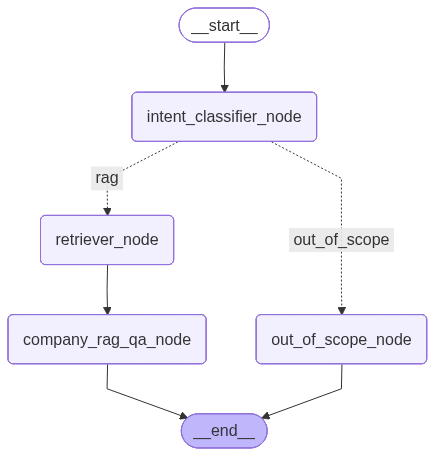

In [99]:
display(Image(app.get_graph().draw_mermaid_png()))

In [100]:
question = "Apa resep untuk membuat rendang?"

initial_state: GraphState = {
    "question": question,
    "intent": "",
    "documents": [],
    "messages": [HumanMessage(content=question)],
    "answer": ""
}

In [101]:
result = app.invoke(initial_state)

Menentukan intent dari pertanyaan...
Menangani pertanyaan di luar cakupan...


In [102]:
result

{'question': 'Apa resep untuk membuat rendang?',
 'intent': 'out_of_scope',
 'documents': [],
 'messages': [HumanMessage(content='\n    Kamu adalah asisten yang sopan dan membantu.\n    Jika pertanyaan pengguna tidak berhubungan dengan informasi perusahaan, produk, atau penanganan keluhan, jawab dengan sopan bahwa kamu tidak dapat membantu dengan pertanyaan tersebut.\n\n    Pertanyaan:\n    Apa resep untuk membuat rendang?\n\n    Jawaban:\n    ', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Maaf, saya tidak dapat membantu dengan pertanyaan tersebut. Saya hanya bisa menjawab pertanyaan terkait informasi perusahaan, produk, atau penanganan keluhan.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--1c081896-1173-429e-8ab3-f671ba875b4c-0', usage_metadata={'input_t

In [103]:
result['answer']

'Maaf, saya tidak dapat membantu dengan pertanyaan tersebut. Saya hanya bisa menjawab pertanyaan terkait informasi perusahaan, produk, atau penanganan keluhan.'